In [1]:
# Imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import sklearn.preprocessing as preproc
import datetime
import matplotlib.dates as dates
# Basic imports
import pandas as pd
import numpy as np

df = pd.read_csv('../../../data/pgaTourData.csv')

In [2]:
df


,Player Name,Rounds,Fairway Percentage,Year,Avg Distance,gir,Average Putts,Average Scrambling,Average Score,Points,Wins,Top 10,Average SG Putts,Average SG Total,SG:OTT,SG:APR,SG:ARG,Money
0,Henrik Stenson,60.0,75.19,2018,291.5,73.51,29.93,60.67,69.617,868,NaN,5.0,-0.207,1.153,0.427,0.960,-0.027,"$2,680,487"
1,Ryan Armour,109.0,73.58,2018,283.5,68.22,29.31,60.13,70.758,"1,006",1.0,3.0,-0.058,0.337,-0.012,0.213,0.194,"$2,485,203"
2,Chez Reavie,93.0,72.24,2018,286.5,68.67,29.12,62.27,70.432,"1,020",NaN,3.0,0.192,0.674,0.183,0.437,-0.137,"$2,700,018"
3,Ryan Moore,78.0,71.94,2018,289.2,68.80,29.17,64.16,70.015,795,NaN,5.0,-0.271,0.941,0.406,0.532,0.273,"$1,986,608"
4,Brian Stuard,103.0,71.44,2018,278.9,67.12,29.11,59.23,71.038,421,NaN,3.0,0.164,0.062,-0.227,0.099,0.026,"$1,089,763"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2307,Carl Paulson,NaN,NaN,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"$16,943"
2308,Peter Tomasulo,NaN,NaN,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"$12,827"
2309,Marc Turnesa,NaN,NaN,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"10,159"
2310,Jesper Parnevik,NaN,NaN,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"9,165"


In [3]:
# Replace NaN with 0 in Top 10
df['Top 10'].fillna(0, inplace=True)
df['Top 10'] = df['Top 10'].astype(int)
# Replace NaN with 0 in # of wins
df['Wins'].fillna(0, inplace=True)
df['Wins'] = df['Wins'].astype(int)
# Drop NaN values
df.dropna(axis = 0, inplace=True)
# Change Rounds to int
df['Rounds'] = df['Rounds'].astype(int)
# Change Points to int
df['Points'] = df['Points'].apply(lambda x: x.replace(',',''))
df['Points'] = df['Points'].astype(int)

df.columns = map(str.lower, df.columns)
df["money"] = df["money"].str.replace("$", "")
df["money"] = df["money"].str.replace(",", "")
df["money"] = df["money"].str.replace(".", "")
df["money"] = df["money"].astype('float64')
df.columns=df.columns.str.replace(' ', '_')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1674 entries, 0 to 1677
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   player_name         1674 non-null   object 
 1   rounds              1674 non-null   int64  
 2   fairway_percentage  1674 non-null   float64
 3   year                1674 non-null   int64  
 4   avg_distance        1674 non-null   float64
 5   gir                 1674 non-null   float64
 6   average_putts       1674 non-null   float64
 7   average_scrambling  1674 non-null   float64
 8   average_score       1674 non-null   float64
 9   points              1674 non-null   int64  
 10  wins                1674 non-null   int64  
 11  top_10              1674 non-null   int64  
 12  average_sg_putts    1674 non-null   float64
 13  average_sg_total    1674 non-null   float64
 14  sg:ott              1674 non-null   float64
 15  sg:apr              1674 non-null   float64
 16  sg:arg

In [5]:
df.corr()

,rounds,fairway_percentage,year,avg_distance,gir,average_putts,average_scrambling,average_score,points,wins,top_10,average_sg_putts,average_sg_total,sg:ott,sg:apr,sg:arg,money
rounds,1.000000,0.081514,0.080201,0.073875,0.249943,-0.127097,0.226248,-0.316830,0.364636,0.103162,0.327737,0.175047,0.319696,0.168305,0.192840,0.111347,0.278091
fairway_percentage,0.081514,1.000000,-0.112507,-0.534017,0.342783,0.163327,0.235679,-0.171164,0.032302,-0.047949,0.041247,-0.043056,0.162895,0.179917,0.155834,-0.001253,0.016237
year,0.080201,-0.112507,1.000000,0.220902,0.000006,-0.144955,0.107640,-0.006374,0.057549,0.039006,0.078516,0.023758,0.029388,0.001588,0.011018,0.034933,0.108244
avg_distance,0.073875,-0.534017,0.220902,1.000000,0.294200,0.168702,-0.228718,-0.272015,0.281107,0.206294,0.267243,-0.137384,0.278270,0.603395,0.142956,-0.190569,0.329295
gir,0.249943,0.342783,0.000006,0.294200,1.000000,0.551015,0.036261,-0.486806,0.303183,0.120340,0.299846,-0.231149,0.489223,0.584433,0.578938,-0.104616,0.313770
average_putts,-0.127097,0.163327,-0.144955,0.168702,0.551015,1.000000,-0.550265,0.262774,-0.282488,-0.168764,-0.282721,-0.720598,-0.265425,0.295616,0.133678,-0.449518,-0.257832
average_scrambling,0.226248,0.235679,0.107640,-0.228718,0.036261,-0.550265,1.000000,-0.519177,0.344421,0.125193,0.347181,0.459051,0.518277,-0.024205,0.195898,0.614123,0.317777
average_score,-0.316830,-0.171164,-0.006374,-0.272015,-0.486806,0.262774,-0.519177,1.000000,-0.763993,-0.390254,-0.728738,-0.364698,-0.962385,-0.530372,-0.670174,-0.391596,-0.746499
points,0.364636,0.032302,0.057549,0.281107,0.303183,-0.282488,0.344421,-0.763993,1.000000,0.750110,0.848195,0.297614,0.761594,0.437439,0.521278,0.284049,0.949286
wins,0.103162,-0.047949,0.039006,0.206294,0.120340,-0.168764,0.125193,-0.390254,0.750110,1.000000,0.473453,0.149155,0.384932,0.232414,0.259363,0.134948,0.721665


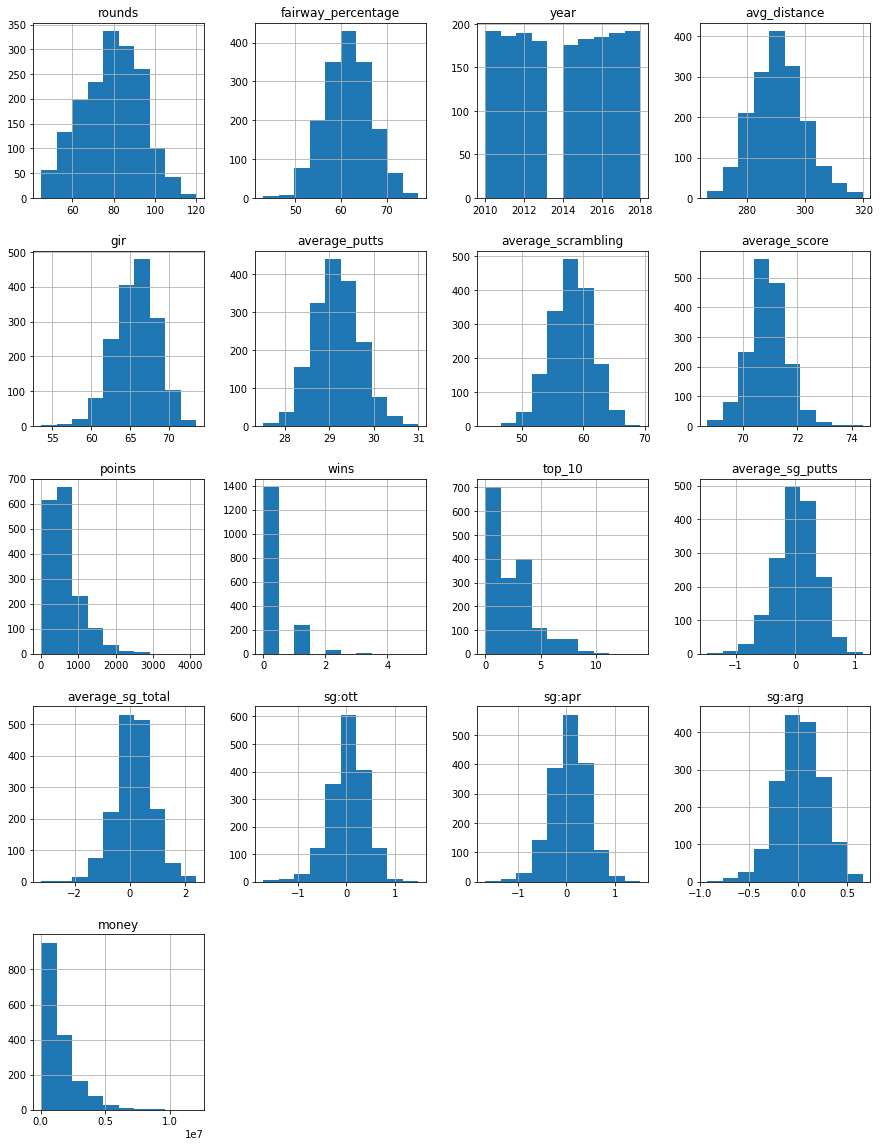

In [6]:
df.hist(figsize = (15,20));

In [7]:
df

,player_name,rounds,fairway_percentage,year,avg_distance,gir,average_putts,average_scrambling,average_score,points,wins,top_10,average_sg_putts,average_sg_total,sg:ott,sg:apr,sg:arg,money
0,Henrik Stenson,60,75.19,2018,291.5,73.51,29.93,60.67,69.617,868,0,5,-0.207,1.153,0.427,0.960,-0.027,2680487.0
1,Ryan Armour,109,73.58,2018,283.5,68.22,29.31,60.13,70.758,1006,1,3,-0.058,0.337,-0.012,0.213,0.194,2485203.0
2,Chez Reavie,93,72.24,2018,286.5,68.67,29.12,62.27,70.432,1020,0,3,0.192,0.674,0.183,0.437,-0.137,2700018.0
3,Ryan Moore,78,71.94,2018,289.2,68.80,29.17,64.16,70.015,795,0,5,-0.271,0.941,0.406,0.532,0.273,1986608.0
4,Brian Stuard,103,71.44,2018,278.9,67.12,29.11,59.23,71.038,421,0,3,0.164,0.062,-0.227,0.099,0.026,1089763.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673,Phil Mickelson,76,52.66,2010,299.1,65.13,28.79,61.84,69.966,1629,1,5,-0.147,1.001,0.185,0.738,0.228,3821733.0
1674,John Daly,63,52.21,2010,305.7,65.66,29.78,53.53,71.697,97,0,0,-0.653,-0.989,0.336,-0.374,-0.298,158587.0
1675,Jimmy Walker,82,51.29,2010,292.9,65.88,29.14,58.46,70.953,554,0,2,0.252,0.093,-0.538,0.336,0.047,937987.0
1676,Daniel Chopra,74,51.27,2010,295.9,61.64,28.88,56.16,72.194,142,0,0,0.361,-1.096,-0.307,-1.070,-0.084,311405.0


In [8]:
def relevants(data):
    rel = []
    for col in data.columns:
        if data[col].dtype != object:
            rel.append(col)
    return rel
def graphs(data):
    relevant = relevants(data.drop('points', axis = 1))
    rowsplot = int(len(relevant)/2 + 1)

    fig, axes = plt.subplots(nrows = rowsplot, ncols = 2, figsize=(20, 100))

    for col, ax in zip(relevant, axes.flatten()):
        sns.scatterplot(data = data, x = col, y = 'points', ax = ax)
        ax.set_title(col, fontsize = 20)

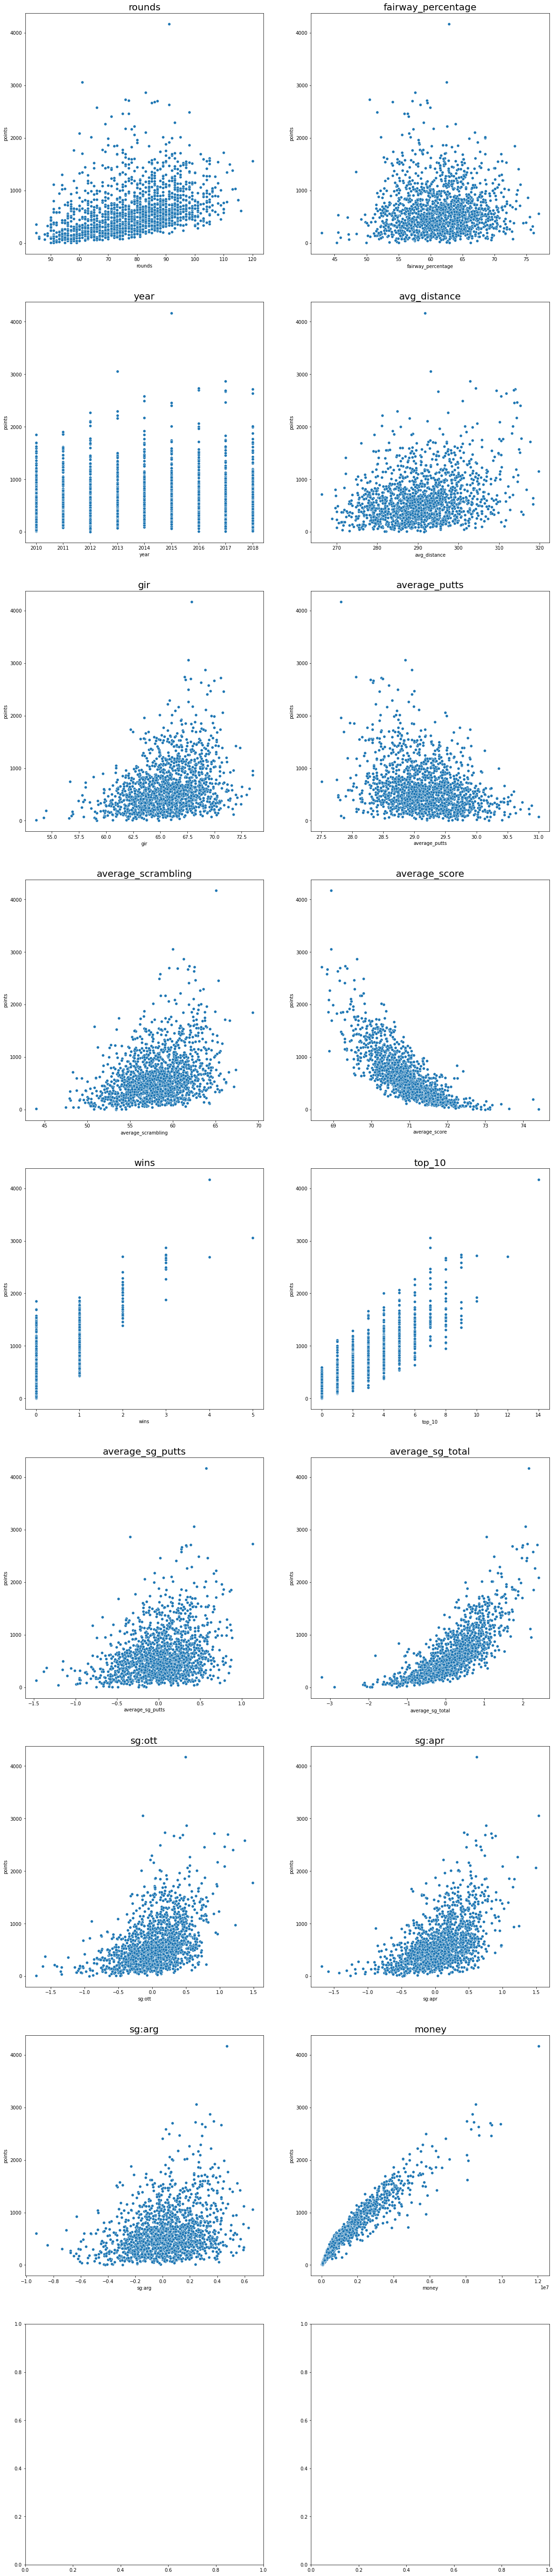

In [9]:
graphs(df)

In [10]:
def make_corrs(data, display = False):
    corrs = data.corr().stack().reset_index()
    corrs = corrs.loc[corrs['level_0'] != corrs['level_1']]
    corrs['pair'] = corrs['level_0'] + ' '+ corrs['level_1']
    corrs['pair'] = corrs['pair'].map(lambda x: ', '.join(sorted(x.split(' '))))
    corrs.drop_duplicates(subset = 'pair', inplace = True)
    corrs.drop(['level_1','level_0'], axis = 1, inplace = True)
    corrs.set_index('pair', inplace = True)
    corrs.columns = pd.Series('correlation')
    corrs = abs(corrs).sort_values('correlation', ascending = False)
    if display:
        display(corrs)
    return corrs

make_corrs(df)

,correlation
pair,
"average_score, average_sg_total",0.962385
"money, points",0.949286
"points, top_10",0.848195
"money, top_10",0.827215
"average_score, points",0.763993
...,...
"sg:apr, year",0.011018
"average_score, year",0.006374
"sg:ott, year",0.001588


In [11]:
def make_corrs_with_money(data, display = False):
    corrs = make_corrs(data)
    corrs_with_money = corrs.loc[corrs.index.str.contains('money')]
    if display:
        display(corrs_with_money)
    return corrs_with_money

make_corrs_with_money(df)

,correlation
pair,
"money, points",0.949286
"money, top_10",0.827215
"average_sg_total, money",0.747042
"average_score, money",0.746499
"money, wins",0.721665
"money, sg:apr",0.510740
"money, sg:ott",0.441912
"avg_distance, money",0.329295
"average_scrambling, money",0.317777


In [12]:
baseline = df.drop(['player_name','fairway_percentage','year'], axis = 1).copy()#####
categoricals = ['points','top_10','average_sg_total','average_score','wins','sg:apr','sg:ott']#######
baseline_dummies = pd.get_dummies(baseline[categoricals], prefix = categoricals, columns = categoricals)
baseline = pd.concat([baseline.drop(categoricals, axis = 1), baseline_dummies], axis = 1)
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
folds = KFold(n_splits = 5, shuffle = True)

X = baseline.drop('money',axis = 1)
y = baseline['money']
trainscores = []
testscores = []
for train_ind, test_ind in folds.split(X):
    X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
    y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
    
    linreg.fit(X_train, y_train)
    trainscores.append(linreg.score(X_train, y_train))
    testscores.append(linreg.score(X_test, y_test))
    
trainscores = np.array(trainscores)
testscores = np.array(testscores)
trainscores.mean(), testscores.mean()

(1.0, 0.8161661470547695)

<AxesSubplot:xlabel='points', ylabel='points'>

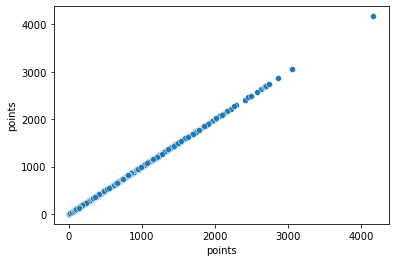

In [13]:
yhat = linreg.predict(X)
sns.scatterplot(x=df['points'], y=df['points'])

In [14]:
points = df['points']

In [15]:
points

0        868
1       1006
2       1020
3        795
4        421
        ... 
1673    1629
1674      97
1675     554
1676     142
1677     137
Name: points, Length: 1674, dtype: int64

In [44]:
points.describe()

count    1674.000000
mean      631.125448
std       452.741472
min         3.000000
25%       322.000000
50%       530.000000
75%       813.750000
max      4169.000000
Name: points, dtype: float64

In [45]:
point1 = df.loc[df['points'] > 814]

In [46]:
point1

,player_name,rounds,fairway_percentage,year,avg_distance,gir,average_putts,average_scrambling,average_score,points,wins,top_10,average_sg_putts,average_sg_total,sg:ott,sg:apr,sg:arg,money,point_range
32,Justin Rose,70,66.02,2018,303.5,69.95,28.67,63.03,68.993,1991,2,8,0.424,1.952,0.551,0.526,0.450,8130678.0,0
39,Rickie Fowler,74,65.33,2018,299.8,69.52,28.99,63.05,69.435,1302,0,4,0.296,1.275,0.244,0.494,0.242,4235237.0,0
46,Francesco Molinari,73,65.04,2018,301.0,70.24,29.63,58.67,69.797,1682,2,4,-0.487,1.123,0.690,0.593,0.327,5065842.0,0
77,Paul Casey,74,63.14,2018,304.3,67.84,29.07,60.58,69.850,1319,1,5,0.133,0.966,0.138,0.586,0.109,3641771.0,0
89,Webb Simpson,95,62.34,2018,293.7,67.93,28.47,66.10,69.293,1710,1,7,0.692,1.432,-0.116,0.486,0.370,5376417.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,Ricky Barnes,103,58.37,2010,285.5,68.23,29.32,59.59,70.470,947,0,6,0.021,0.604,-0.244,0.675,0.149,1835195.0,1
1646,Geoff Ogilvy,62,57.94,2010,287.0,67.69,29.22,56.16,70.764,815,1,1,0.370,0.735,-0.165,0.488,0.041,2393045.0,1
1648,Jason Day,82,57.78,2010,298.2,67.68,29.15,60.38,70.274,988,1,3,-0.009,0.738,0.254,0.054,0.444,2904327.0,1
1649,Ryan Palmer,84,57.23,2010,295.8,65.48,28.77,55.56,70.824,1071,1,3,0.433,0.294,0.175,0.010,-0.324,2985296.0,1


In [47]:
point2 = df.loc[(df['points'] < 814) & (df['points'] > 530)]

In [48]:
point2

,player_name,rounds,fairway_percentage,year,avg_distance,gir,average_putts,average_scrambling,average_score,points,wins,top_10,average_sg_putts,average_sg_total,sg:ott,sg:apr,sg:arg,money,point_range
3,Ryan Moore,78,71.94,2018,289.2,68.80,29.17,64.16,70.015,795,0,5,-0.271,0.941,0.406,0.532,0.273,1986608.0,1
8,Russell Henley,77,70.03,2018,293.0,68.77,29.80,54.33,70.489,569,0,3,0.167,0.541,0.093,0.467,-0.186,1516438.0,1
11,Kevin Streelman,94,69.11,2018,295.1,71.56,29.67,60.93,70.436,673,0,5,-0.250,0.619,0.439,0.415,0.014,1523642.0,1
12,C.T. Pan,104,68.98,2018,292.7,71.20,29.66,56.89,70.457,693,0,1,-0.067,0.478,0.215,0.267,0.063,1881787.0,1
15,Rafa Cabrera Bello,75,67.85,2018,295.1,70.16,29.47,57.98,69.887,784,0,4,0.273,1.112,0.256,0.487,0.096,2449869.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645,Marc Leishman,87,58.37,2010,295.0,66.67,29.44,56.90,70.769,738,0,2,-0.146,0.418,0.074,0.417,0.072,1488837.0,1
1652,Matt Jones,89,57.07,2010,293.3,65.29,28.65,60.61,70.605,647,0,5,0.509,0.495,-0.122,-0.219,0.321,1215743.0,1
1654,Padraig Harrington,57,56.70,2010,292.1,61.90,28.30,61.20,70.174,662,0,5,0.267,1.063,-0.104,0.524,0.379,1381453.0,1
1666,Charles Howell III,103,54.58,2010,294.3,68.57,28.96,64.46,70.292,746,0,4,0.452,0.784,-0.041,0.046,0.324,1482211.0,1


In [49]:
point3 = df.loc[df['points'] < 530]

In [50]:
point3

,player_name,rounds,fairway_percentage,year,avg_distance,gir,average_putts,average_scrambling,average_score,points,wins,top_10,average_sg_putts,average_sg_total,sg:ott,sg:apr,sg:arg,money,point_range
4,Brian Stuard,103,71.44,2018,278.9,67.12,29.11,59.23,71.038,421,0,3,0.164,0.062,-0.227,0.099,0.026,1089763.0,1
19,Vaughn Taylor,83,67.51,2018,286.1,67.02,29.15,59.91,70.692,445,0,3,-0.080,0.219,-0.005,0.305,-0.002,965691.0,1
21,Sam Ryder,82,66.91,2018,297.3,72.08,29.88,56.47,70.914,442,0,3,-0.349,0.154,0.203,0.399,-0.099,1046166.0,1
24,Tyler Duncan,97,66.74,2018,294.4,69.65,30.19,52.76,71.040,457,0,2,-0.566,0.017,0.273,0.476,-0.166,944021.0,1
26,Alex Cejka,77,66.49,2018,286.7,63.77,28.52,64.00,70.675,502,0,2,0.009,0.312,-0.024,-0.169,0.495,1198541.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1671,Tim Herron,79,53.49,2010,291.7,66.51,29.36,58.86,71.171,234,0,0,0.171,-0.227,-0.233,-0.211,0.044,391502.0,0
1672,Rich Barcelo,70,52.80,2010,287.6,61.72,28.97,54.20,71.751,187,0,0,0.144,-0.520,-1.027,0.228,0.130,188892.0,0
1674,John Daly,63,52.21,2010,305.7,65.66,29.78,53.53,71.697,97,0,0,-0.653,-0.989,0.336,-0.374,-0.298,158587.0,0
1676,Daniel Chopra,74,51.27,2010,295.9,61.64,28.88,56.16,72.194,142,0,0,0.361,-1.096,-0.307,-1.070,-0.084,311405.0,0


In [51]:
point3['point_range'] = 0

<ipython-input-51-07c4207f55e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  point3['point_range'] = 0


In [52]:
point1['point_range'] = 0

<ipython-input-52-5bf5279500b9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  point1['point_range'] = 0


In [53]:
point2['point_range'] = 1

<ipython-input-53-36d10b65ea5e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  point2['point_range'] = 1


In [54]:
point3['point_range']

4       0
19      0
21      0
24      0
26      0
       ..
1671    0
1672    0
1674    0
1676    0
1677    0
Name: point_range, Length: 834, dtype: int64

In [55]:
point2['point_range']

3       1
8       1
11      1
12      1
15      1
       ..
1645    1
1652    1
1654    1
1666    1
1675    1
Name: point_range, Length: 416, dtype: int64

In [56]:
point1['point_range']

32      0
39      0
46      0
77      0
89      0
       ..
1644    0
1646    0
1648    0
1649    0
1668    0
Name: point_range, Length: 418, dtype: int64

In [57]:
frames = [point1, point2, point3]

df = pd.concat(frames)

In [58]:
df

,player_name,rounds,fairway_percentage,year,avg_distance,gir,average_putts,average_scrambling,average_score,points,wins,top_10,average_sg_putts,average_sg_total,sg:ott,sg:apr,sg:arg,money,point_range
32,Justin Rose,70,66.02,2018,303.5,69.95,28.67,63.03,68.993,1991,2,8,0.424,1.952,0.551,0.526,0.450,8130678.0,0
39,Rickie Fowler,74,65.33,2018,299.8,69.52,28.99,63.05,69.435,1302,0,4,0.296,1.275,0.244,0.494,0.242,4235237.0,0
46,Francesco Molinari,73,65.04,2018,301.0,70.24,29.63,58.67,69.797,1682,2,4,-0.487,1.123,0.690,0.593,0.327,5065842.0,0
77,Paul Casey,74,63.14,2018,304.3,67.84,29.07,60.58,69.850,1319,1,5,0.133,0.966,0.138,0.586,0.109,3641771.0,0
89,Webb Simpson,95,62.34,2018,293.7,67.93,28.47,66.10,69.293,1710,1,7,0.692,1.432,-0.116,0.486,0.370,5376417.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1671,Tim Herron,79,53.49,2010,291.7,66.51,29.36,58.86,71.171,234,0,0,0.171,-0.227,-0.233,-0.211,0.044,391502.0,0
1672,Rich Barcelo,70,52.80,2010,287.6,61.72,28.97,54.20,71.751,187,0,0,0.144,-0.520,-1.027,0.228,0.130,188892.0,0
1674,John Daly,63,52.21,2010,305.7,65.66,29.78,53.53,71.697,97,0,0,-0.653,-0.989,0.336,-0.374,-0.298,158587.0,0
1676,Daniel Chopra,74,51.27,2010,295.9,61.64,28.88,56.16,72.194,142,0,0,0.361,-1.096,-0.307,-1.070,-0.084,311405.0,0


In [59]:
df['point_range'].value_counts()

0    1252
1     416
Name: point_range, dtype: int64

In [60]:
df_2010 = df.loc[df['year'] == 2010]

In [61]:
df_2011 = df.loc[df['year'] == 2011]

In [62]:
df_2012 = df.loc[df['year'] == 2012]

In [63]:
df_2013 = df.loc[df['year'] == 2013]

In [64]:
df_2014 = df.loc[df['year'] == 2014]

In [65]:
df_2015 = df.loc[df['year'] == 2015]

In [66]:
df_2016 = df.loc[df['year'] == 2016]

In [67]:
df_2017 = df.loc[df['year'] == 2017]

In [68]:
df_2018 = df.loc[df['year'] == 2018]

In [103]:
dataframes = [df_2010,df_2011,df_2012, df_2013, df_2014, df_2015, df_2016, df_2017]

df_10_17 = pd.concat(dataframes)

In [106]:
lr = LogisticRegression()

Accuracy of logistic regression classifier on test set: 0.74479


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


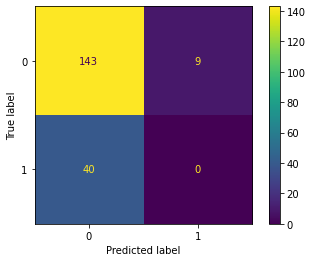

In [107]:
X_train = df_10_17.drop(columns= ['points','top_10','money','point_range','player_name'], axis = 1)

y_train = df_10_17['point_range']


X_test = df_2018.drop(columns= ['points','top_10','money','point_range','player_name'], axis = 1)
y_test = df_2018['point_range']

#I scale the X_train and X_test data.
sc = StandardScaler()

X_train_s = sc.fit(X_train).transform(X_train)
X_test_s = sc.transform(X_test)

#Here I select particular variables from X to use for the logistic regression.
#cols=['RPI Last Season','AP Votes', 'Coaches Votes','OPPP','OFGm','OFGM','OPerTO','DPerFT','OaFGPer']
#Now form dataframes from the scaled but not oversampled data with just those␣ 􏰁→columns
#X_s=X_s_data[cols]
#y_s=y_s_data['Sweet 16']
#Form dataframe for X_test_s using only columns specified.
#X_test_s_df_c=X_test_s_df[cols]


lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(accuracy_score(y_test, y_pred)))

plot_confusion_matrix(lr,X_test, y_test) 